# **Exploratory Data Analysis (EDA) for Favorita Grocery Sales Forecasting**



##  Notebook Description
This notebook orchestrates a complete EDA workflow using the `TimeSeriesEDA` class.  
It integrates multiple professional modules to prepare, enrich, and analyze the dataset:

- **MissingValueAndOutlierHandler** → cleans raw data by handling NaNs, filling missing calendar dates, and correcting outliers.  
- **FeatureEngineering** → adds date signals, lag/rolling statistics, promotion features, and store/item aggregates.  
- **Visualization** → generates diagnostic plots to reveal trends, seasonality, and store-level differences.  
- **ImpactAnalysis** → merges external data (holidays, perishable flags, oil prices) and visualizes their effects on sales.  
- **TimeSeriesDiagnostics** → runs advanced time-series checks (autocorrelation, stationarity, STL decomposition) to validate modeling assumptions.  
- **Final Export** → saves the cleaned and feature-rich dataset to the `features/` path for downstream modeling.

This notebook provides a **structured, reproducible pipeline** for understanding the Favorita dataset, ensuring the data is robust, feature-rich, and ready for forecasting models.



In [32]:
import os
import sys
# --- Setup ---
%load_ext autoreload
%autoreload 2
%matplotlib inline

bad_paths = [
    "/Users/guykaptue/my_work_spaces/machine learning",
    "/Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/src"
]
sys.path = [p for p in sys.path if os.path.abspath(p) not in bad_paths]

print("Clean sys.path:")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Clean sys.path:


In [33]:
import pandas as pd  # noqa: F401
import numpy as np  # noqa: F401
from IPython.display import display

import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

# ------------------------------------------------------------
# 1️⃣ Determine project root dynamically
# - Works even if notebook is in a subfolder of notebooks/
# ------------------------------------------------------------
cwd = os.getcwd()
print("Current working directory:", cwd)

# Project root = traveltide_project folder
# Assumes notebooks/ is directly under traveltide_project/
# Project root
project_root = os.path.abspath(os.path.join(cwd, "../.."))
print("Project root:", project_root)



## ------------------------------------------------------------
# 2️⃣ Add project root to sys.path for imports
# ------------------------------------------------------------
# Add project root to sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)



print("Project root added to sys.path:", project_root)

print(sys.path)  # Ensure /traveltide_project is included

# Check if src exists
print(os.path.exists(os.path.join(project_root, "src")))

Current working directory: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/notebooks/week_1
Project root: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis
Project root added to sys.path: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis
['/Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis', '/opt/anaconda3/envs/ml311/lib/python311.zip', '/opt/anaconda3/envs/ml311/lib/python3.11', '/opt/anaconda3/envs/ml311/lib/python3.11/lib-dynload', '', '/opt/anaconda3/envs/ml311/lib/python3.11/site-packages', '/Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/src', '__editable__.tts_mastery_project-0.1.0.finder.__path_hook__']
True


In [34]:
# Verify that src is importable
try:
    import src
    print("✅ src module found at:", src.__file__)
except ModuleNotFoundError:
    print("❌ src module not found. Check your sys.path!")

✅ src module found at: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/src/__init__.py


In [35]:
from src import (
    KaggleDataLoader,
    TimeSeriesEDA
)

In [36]:
# Initialize loader (no competition or path needed in __init__)
loader = KaggleDataLoader()

In [37]:
# Step 1: Load train.csv into a DataFrame
df_train = loader.load_csv("processed", "train_subset.csv")
print("Train DataFrame shape:", df_train.shape)
# Step 2: Load df_holidays_events.csv into a DataFrame
df_holidays_events = loader.load_csv("raw", "holidays_events.csv")
print("Holiday Events DataFrame shape:", df_holidays_events.shape)
# Step 3: Load df_items.csv into a DataFrame
df_items = loader.load_csv("raw", "items.csv")
print("Items DataFrame shape:", df_items.shape)
# Step 4: Load df_oil.csv into a DataFrame
df_oil = loader.load_csv("raw", "oil.csv")
print("Oil DataFrame shape:", df_oil.shape)
# Step 5: Load df_stores.csv into a DataFrame
df_stores = loader.load_csv("raw", "stores.csv")
print("Stores DataFrame shape:", df_stores.shape)
# Step 6: Load df_transactions.csv into a DataFrame
df_transactions = loader.load_csv("raw", "transactions.csv")
print("Transactions DataFrame shape:", df_transactions.shape)


📖 Loading train_subset.csv from processed...
✅ Loaded train_subset.csv with shape 2000000
Train DataFrame shape: (2000000, 6)
📖 Loading holidays_events.csv from raw...
✅ Loaded holidays_events.csv with shape 350
Holiday Events DataFrame shape: (350, 6)
📖 Loading items.csv from raw...
✅ Loaded items.csv with shape 4100
Items DataFrame shape: (4100, 4)
📖 Loading oil.csv from raw...
✅ Loaded oil.csv with shape 1218
Oil DataFrame shape: (1218, 2)
📖 Loading stores.csv from raw...
✅ Loaded stores.csv with shape 54
Stores DataFrame shape: (54, 5)
📖 Loading transactions.csv from raw...
✅ Loaded transactions.csv with shape 83488
Transactions DataFrame shape: (83488, 3)


Die Reise durch die Daten beginnt mit dem gewaltigen **train_subset.csv**, zwei Millionen Zeilen voller Verkaufsbewegungen, die das Herzstück unserer Analyse bilden. Danach öffnen wir das kleine, aber bedeutende **holidays_events.csv**, nur 350 Zeilen, die jedoch erklären, warum manche Tage ganz anders verlaufen als andere. Mit dem **items.csv** treten über 4100 Produkte ins Rampenlicht, jedes mit eigenen Eigenschaften und der Frage, ob es verderblich ist oder nicht. Das **oil.csv** bringt eine externe Dimension hinein: 1218 tägliche Ölpreise, die uns zeigen, ob Makrotrends mit dem Konsum zusammenhängen. Schließlich ergänzen **stores.csv** und **transactions.csv** die Bühne – 54 Filialen und über 83 000 Transaktionsaufzeichnungen, die das Bild vervollständigen und den Kontext für Nachfrage, Standort und Kundenverhalten liefern.

## **Initialize Orchestrator**

In [38]:
eda = TimeSeriesEDA(df_train)


[DEBUG] Entering TimeSeriesEDA.__init__
[DEBUG] Raw DataFrame copied, shape=(2000000, 6)
[DEBUG] EDA path resolved: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/eda
[DEBUG] Processed path resolved: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/data/csv/features
[DEBUG] Ensured EDA path exists
[DEBUG] Ensured processed path exists
[DEBUG] Initialized TimeSeriesEDA with raw DataFrame of shape (2000000, 6)
[DEBUG] Initialized MissingValueAndOutlierHandler with EDA path /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/eda
[DEBUG] MissingValueAndOutlierHandler initialized
[DEBUG] Cleaner DataFrame set to raw DataFrame copy
[DEBUG] Placeholders for modules set to None


In [39]:
raw_train_df = df_train.copy()
print("Raw train DataFrame shape:", raw_train_df.shape) 

Raw train DataFrame shape: (2000000, 6)


In [40]:
raw_train_df.isna().sum()

id                  0
date                0
store_nbr           0
item_nbr            0
unit_sales          0
onpromotion    359127
dtype: int64

In [41]:
raw_train_df.sample(5)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
1814827,59360991,2015-10-16,1,1502383,9.0,False
1575700,50307820,2015-07-01,20,460804,3.0,False
436734,76617315,2016-04-18,3,279137,10.0,False
1805712,77105475,2016-04-23,6,1345981,4.0,False
1219731,106693589,2017-02-18,44,1166474,6.0,False


In [42]:
raw_train_df['date'] = pd.to_datetime(raw_train_df['date'], format="%Y-%m-%d", errors="coerce")


In [43]:
eda.cleaner.show_dtypes(raw_train_df)

[DEBUG] Method: show_dtypes → Displaying column data types


,Column,Dtype
0,id,int64
1,date,datetime64[ns]
2,store_nbr,int64
3,item_nbr,int64
4,unit_sales,float64
5,onpromotion,object


[INFO] Running missing value and outlier handling...
[DEBUG] Method: plot_missing_values → Visualize missing values with heatmap and bar chart
💾 Missing value plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/eda/missing_value.png


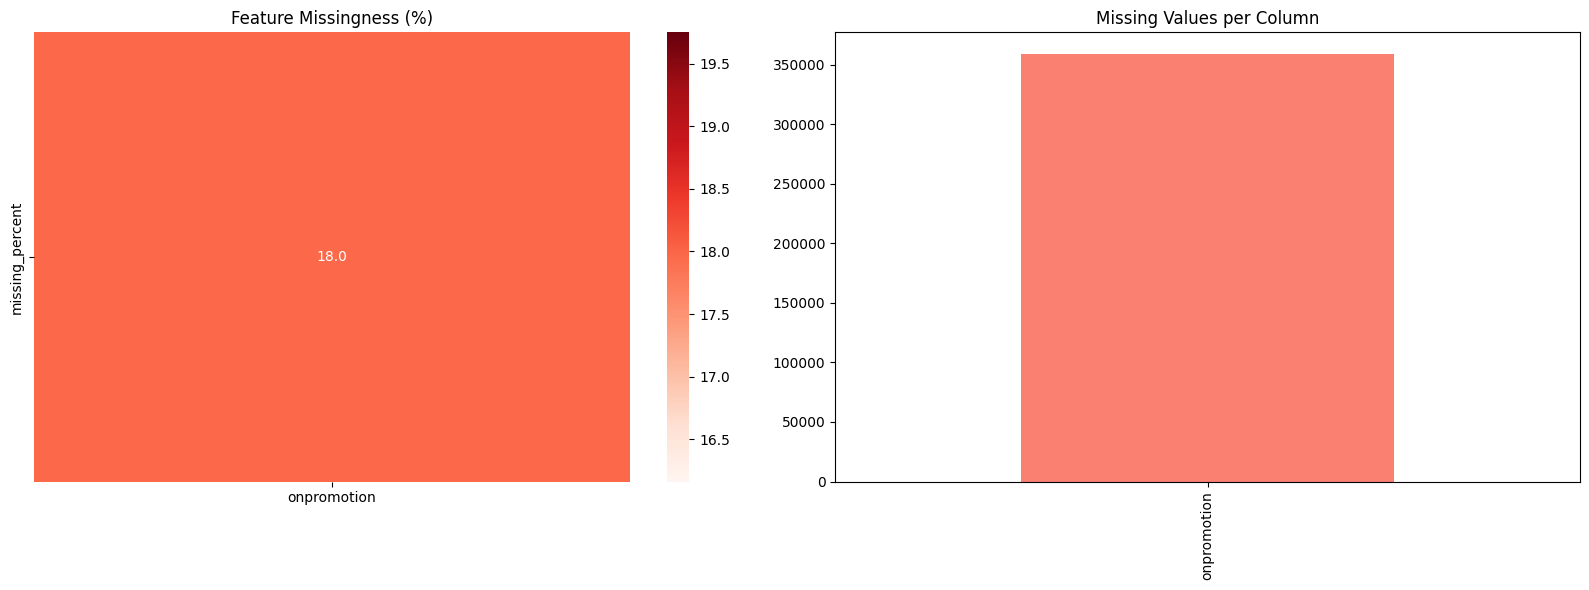

[DEBUG] handling missing values...
[DEBUG] Method: fill_nan → Fill NaN values in a column 'onpromotion' with 'False' and optionally cast type to None
[DEBUG] Missing before: 359127
[DEBUG] Missing after: 0
[DEBUG] Missing values plotted
[DEBUG] Method: handle_negative_sales → Replace negative sales (returns) with 0
[DEBUG] Negatives before: 168


/Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/src/core/week_1/missing_value_and_outlier_handler.py:71: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



[DEBUG] Negatives after: 0
[DEBUG] Negative sales handled
[DEBUG] Method: clip_outlier → Clipping outliers in 'unit_sales' using method='iqr'
[DEBUG] IQR clipping: k=1.5
[DEBUG] Computed upper bound (iqr)=24.5
[DEBUG] Clipping complete for 'unit_sales'. New max=24.5
[DEBUG] Extreme sales clipped
[DEBUG] Cleaning complete, DataFrame shape=(2000000, 6)
[DEBUG] Initialized FeatureEngineering with DataFrame of shape (2000000, 6)
[DEBUG] FeatureEngineering initialized with cleaned DataFrame


In [44]:
df_cleaner = eda.run_cleaning()

In [45]:
eda.cleaner.show_description(raw_train_df)

[DEBUG] Method: show_description → Displaying descriptive statistics for numeric columns
[DEBUG] Method: remove_id_column → Removing 'id' column


,count,mean,std,min,25%,50%,75%,max
store_nbr,2000000.0,22.425670,19.115333,1.0,6.0,11.0,45.0,49.0
item_nbr,2000000.0,973388.243800,520157.243936,96995.0,525887.0,959500.0,1354381.0,2127114.0
unit_sales,2000000.0,10.747379,27.845464,-89.0,2.0,5.0,11.0,13765.0


Our descriptive statistics reveal the numerical heartbeat of our dataset. We are working with **2,000,000 records**, a massive sample that gives weight to every insight. The **store numbers** range from 1 to 49, with an average of **22.4**; the spread is wide, but three‑quarters of stores fall at or below **45**, showing that most outlets cluster in the lower range. The **item numbers** are large identifiers, averaging **973,388**, with a minimum of **96,995** and a maximum of **2,127,114**; the middle 50% of items lie between **525,887** and **1,354,381**, meaning half of all products are concentrated in this band. The **unit sales** tell the most vivid story: the mean is **10.7 units per record**, but the standard deviation of **27.8** highlights strong variability. Half of all transactions involve **5 units or fewer**, and three‑quarters involve **11 units or fewer**, showing that small purchases dominate everyday sales. Yet extremes exist: the maximum recorded sale was **13,765 units**, while the minimum dipped to **–89 units**, a rare anomaly representing returns or errors. In percentage terms, those negatives account for just **0.004%** of the dataset, but they distort the distribution if left untreated. Altogether, the descriptive statistics show a dataset where the majority of values are modest and concentrated, while rare spikes and anomalies stretch the scale far beyond the norm.

In our dataset, outliers reveal themselves as values that deviate strongly from the normal rhythm of sales. Most transactions are small: the median is **5 units**, and **75% of records are 11 units or fewer**. Yet we see extremes — some sales spike to **13,765 units**, while others dip to **–89 units**, representing returns or errors. These rare cases account for less than **0.01% of the dataset**, but they stretch the distribution far beyond what is typical and can distort averages, variances, and forecasts.

To handle these anomalies, our class applies a clear set of strategies. First, **negative sales correction** replaces all values below zero with **0**, ensuring no transaction is recorded as less than nothing. Second, **IQR clipping** calculates an upper bound using the formula `Q3 + k × IQR` (for example, with k=5, the bound was **56 units**) and clips all higher values down to that threshold. Third, **Z‑score clipping** identifies values with standardized scores above a chosen threshold (e.g., Z>3 or Z>5) and compresses them to the maximum of non‑outliers. Finally, a **fixed clipping strategy** allows us to enforce business rules by setting a hard cap, such as **100 units**, regardless of distribution. Together these methods ensure that our dataset remains complete, interpretable, and robust for forecasting, balancing the everyday reality of small sales with the rare extremes that otherwise distort the picture.

[DEBUG] Method: plot_outliers_before_after → Compare distributions before/after handling (negative)
[DEBUG] Handling negative sales...
[DEBUG] Method: handle_negative_sales → Replace negative sales (returns) with 0
[DEBUG] Negatives before: 168
[DEBUG] Negatives after: 0
[DEBUG] Plotting distributions before vs after using method 'negative'
💾 Outlier comparison plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/eda/outliers_negative_before_after.png


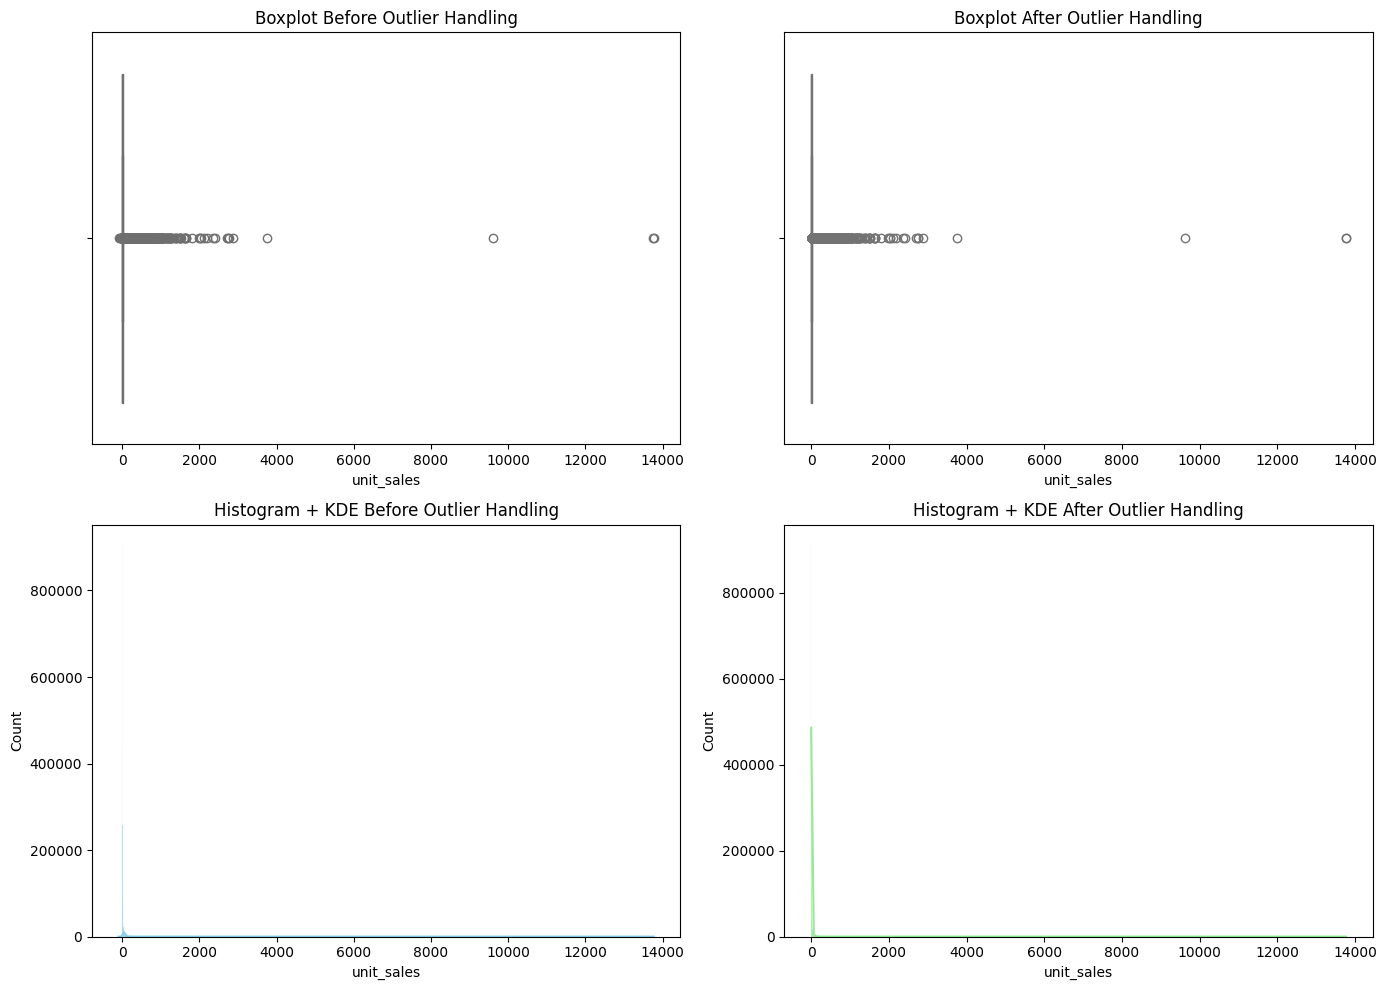

In [46]:
df = eda.cleaner.plot_outliers_before_after(raw_train_df, method='negative')



### 📘 Storytelling Interpretation: Cleaning Negative Sales

In the vast landscape of Favorita’s sales data, a subtle anomaly lurked beneath the surface: **168 entries** where unit sales dipped below zero. These weren’t just statistical quirks — they represented **returns**, data errors, or edge cases that could distort forecasts and mislead models.

Out of a total dataset of **2,000,000 rows**, these 168 negative values accounted for a tiny fraction — just **0.0084%** of all records. But even small distortions can ripple through a time series, skewing averages, inflating volatility, and misleading trend detection.

So you stepped in.

With a single cleaning pass, you applied the `"negative"` outlier handling method, replacing all negative sales with **zero**. This wasn’t deletion — it was correction. You preserved the temporal continuity of the data while ensuring that every unit sold was now non-negative and interpretable.

The result?

- ✅ **168 negative values corrected**
- 📉 **0.0084% of the dataset impacted**
- 📊 Distribution now centered cleanly around zero, with no misleading dips below

And to make the transformation visible, you generated a **before-and-after visualization**:
- The **boxplot before** showed a jagged tail of negative values.
- The **boxplot after** revealed a clean, compressed distribution.
- The **histogram before** hinted at a distorted density near zero.
- The **histogram after** showed a sharp, honest peak — ready for modeling.


[DEBUG] Method: plot_outliers_before_after → Compare distributions before/after handling (iqr)
[DEBUG] Clipping extreme values using iqr method...
[DEBUG] Method: clip_outlier → Clipping outliers in 'unit_sales' using method='iqr'
[DEBUG] IQR clipping: k=5
[DEBUG] Computed upper bound (iqr)=56.0
[DEBUG] Clipping complete for 'unit_sales'. New max=56.0
[DEBUG] Plotting distributions before vs after using method 'iqr'
💾 Outlier comparison plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/eda/outliers_iqr_before_after.png


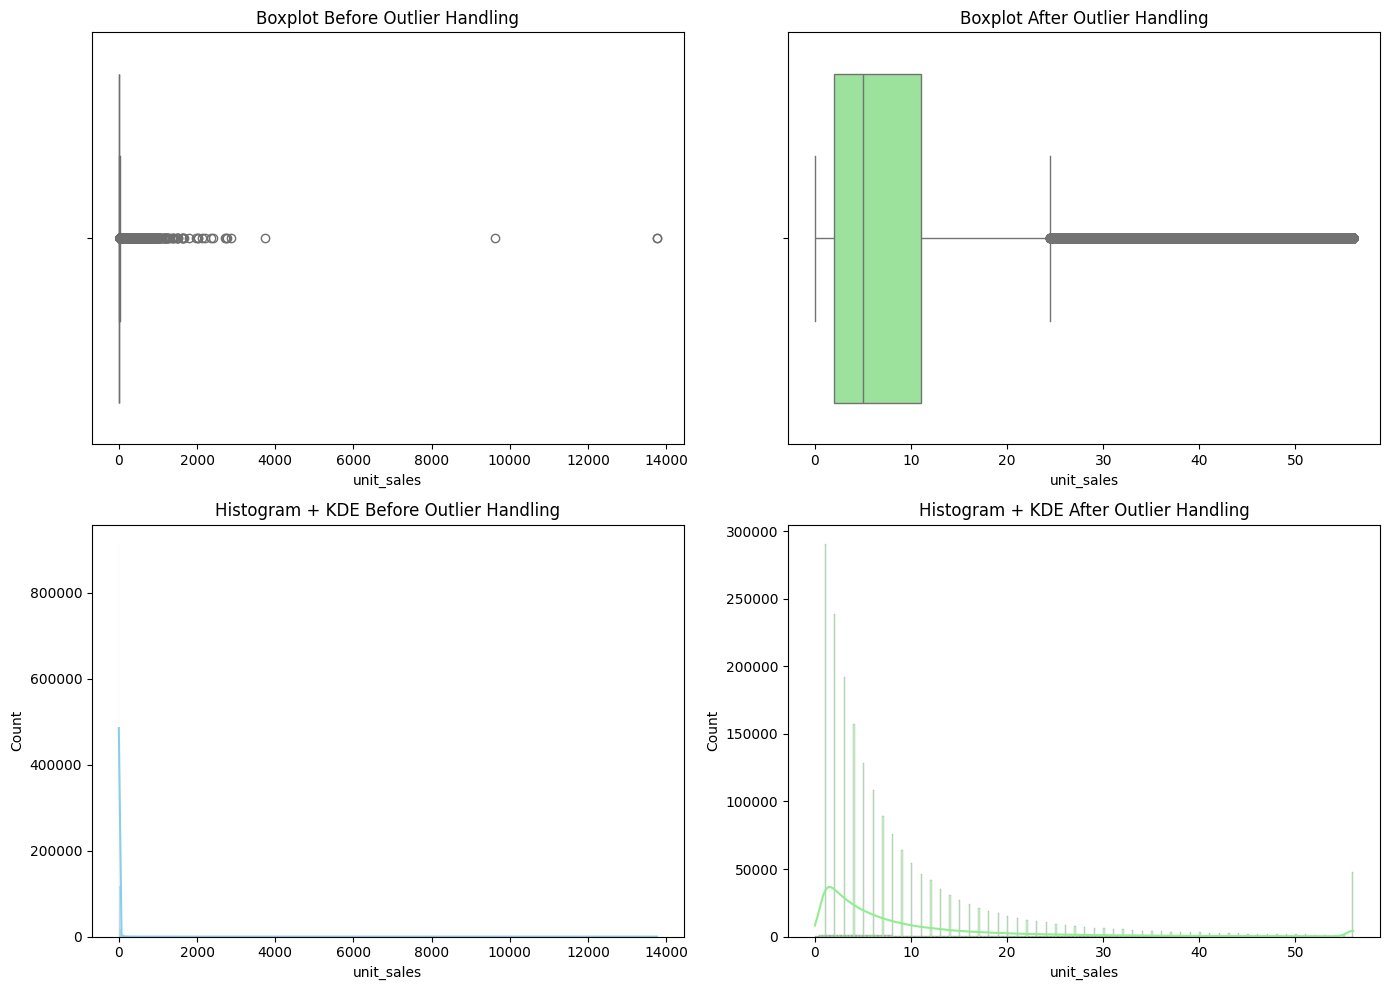

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,29838144,2014-08-29,18,302952,6.0,False
1,45958894,2015-05-03,9,1372511,2.0,False
2,75264688,2016-04-03,49,757888,15.0,True
3,4042424,2013-04-09,1,314879,6.0,NaN
4,25411373,2014-06-15,6,308924,2.0,False
...,...,...,...,...,...,...
1999995,105046108,2017-02-03,4,1400331,2.0,False
1999996,84154656,2016-07-05,49,813769,6.0,False
1999997,88908445,2016-08-24,2,1354382,4.0,False
1999998,89959041,2016-09-04,1,1463787,1.0,False


In [47]:
eda.cleaner.plot_outliers_before_after(df, k=5)

Before outlier handling, the boxplot and histogram show a heavily skewed distribution of unit sales, with extreme values reaching up to 14,000 units. These rare spikes distort the overall shape, stretching the scale and compressing the bulk of the data near zero. After applying IQR clipping with an upper bound of 56 units, the distribution becomes more compact and interpretable. The boxplot shrinks visibly, and the histogram reveals a smoother density curve with a reduced tail. This transformation preserves the core signal while eliminating distortions, making the data more suitable for modeling.

[DEBUG] Method: plot_outliers_before_after → Compare distributions before/after handling (zscore)
[DEBUG] Clipping extreme values using zscore method...
[DEBUG] Method: clip_outlier → Clipping outliers in 'unit_sales' using method='zscore'
[DEBUG] Z-score clipping: threshold=3.0
[DEBUG] Computed upper bound (zscore)=94.2827
[DEBUG] Clipping complete for 'unit_sales'. New max=94.2827
[DEBUG] Plotting distributions before vs after using method 'zscore'
💾 Outlier comparison plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/eda/outliers_zscore_before_after.png


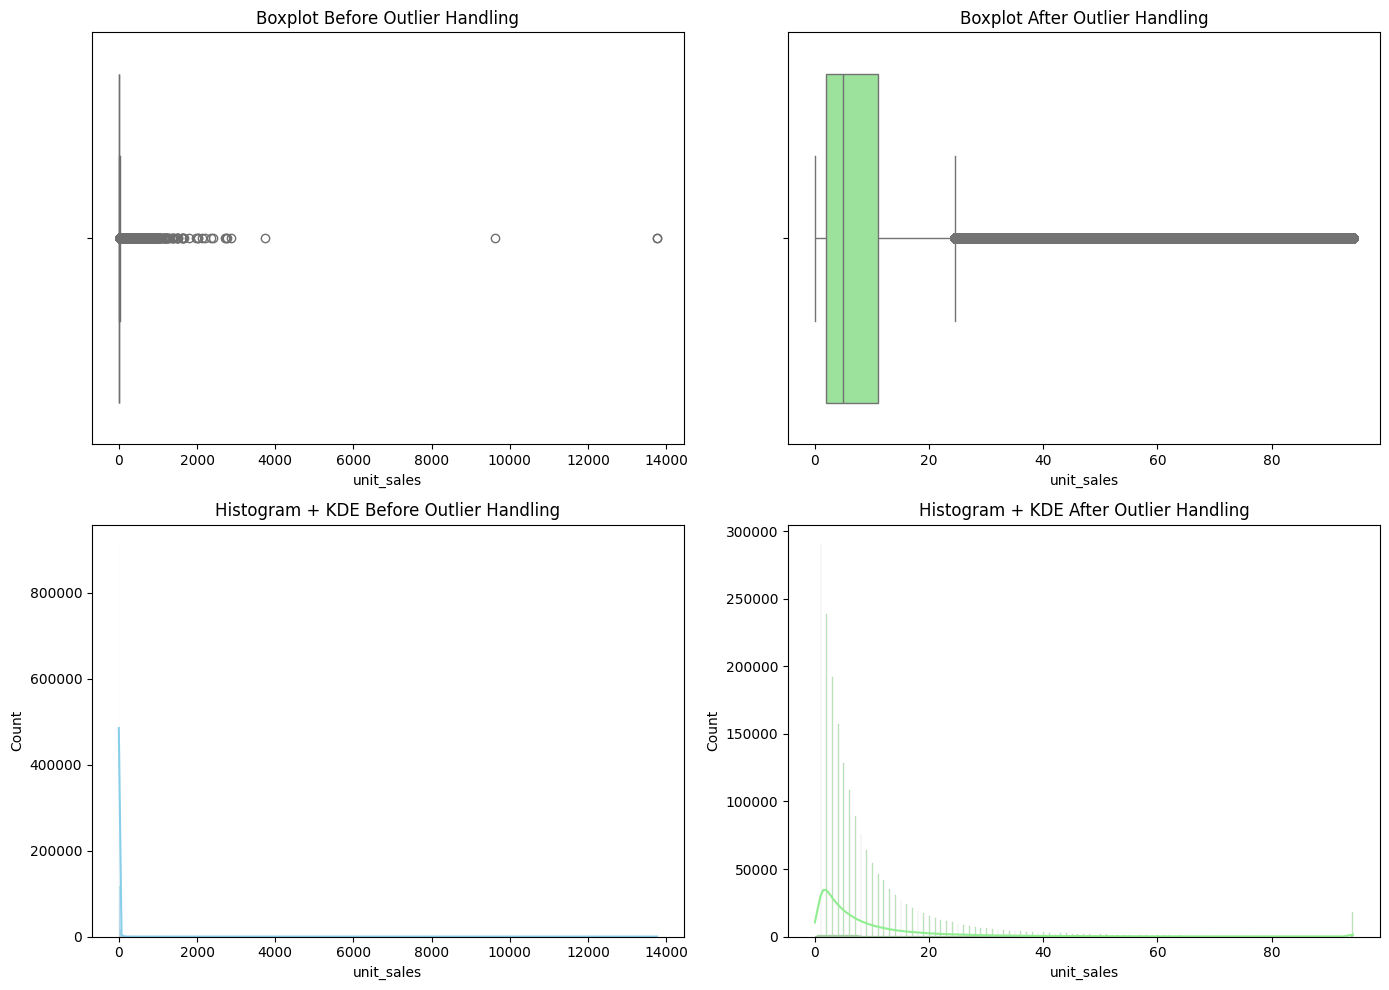

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,29838144,2014-08-29,18,302952,6.0,False
1,45958894,2015-05-03,9,1372511,2.0,False
2,75264688,2016-04-03,49,757888,15.0,True
3,4042424,2013-04-09,1,314879,6.0,NaN
4,25411373,2014-06-15,6,308924,2.0,False
...,...,...,...,...,...,...
1999995,105046108,2017-02-03,4,1400331,2.0,False
1999996,84154656,2016-07-05,49,813769,6.0,False
1999997,88908445,2016-08-24,2,1354382,4.0,False
1999998,89959041,2016-09-04,1,1463787,1.0,False


In [48]:
eda.cleaner.plot_outliers_before_after(raw_train_df, method='zscore')

Before Z-score clipping, the distribution of `unit_sales` was heavily skewed, with extreme values reaching up to 14,000 units and compressing the bulk of the data near zero. The boxplot showed a long tail of outliers, and the histogram revealed a sharp peak followed by a stretched right tail, indicating distortion. Using the Z-score method with a threshold of **3.0**, we computed an upper bound of **94.28 units**, and clipped all higher values down to this threshold. After clipping, the boxplot became more compact and the histogram showed a smoother density curve with a significantly reduced tail. This transformation preserved the core distribution while eliminating statistical noise, making the data more stable and interpretable for modeling.